## Imports

In [1]:
import sys
import importlib
importlib.reload(sys)
for p in sys.path:
    print (p)

/exports/commonscratch/how/dostools/tests2
/home/how/anaconda3/lib/python39.zip
/home/how/anaconda3/lib/python3.9
/home/how/anaconda3/lib/python3.9/lib-dynload

/home/how/.local/lib/python3.9/site-packages
/home/how/anaconda3/lib/python3.9/site-packages
/exports/commonscratch/how/dostools/src


In [31]:
import dostools
import importlib
import numpy as np
import pickle
import torch
import sys
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm
import time
import matplotlib
torch.set_default_dtype(torch.float64) 
%matplotlib notebook
matplotlib.rcParams['figure.figsize'] = (10, 10)
sys.modules['dostools.src'] = dostools

In [4]:
import dostools.datasets.data as data
import dostools.utils.utils as utils

n_structures = 1039
np.random.seed(0)
n_train = int(0.8 * n_structures)
train_index = np.arange(n_structures)
np.random.shuffle(train_index)
test_index = train_index[n_train:]
train_index = train_index[:n_train]

with torch.no_grad():
    structures = data.load_structures(":")
    n_structures = len(structures) #total number of structures
    for structure in structures:#implement periodicity
        structure.wrap(eps = 1e-12) 
    n_atoms = np.zeros(n_structures, dtype = int) #stores number of atoms in each structures
    for i in range(n_structures):
        n_atoms[i] = len(structures[i])

    #eigenergies, emin, emax = dostools.src.datasets.data.load_eigenenergies(unpack = True, n_structures = len(structures))
    xdos = torch.tensor(data.load_xdos())
    ldos = torch.tensor(data.load_ldos())
    ldos *= 2

    print ("ldos shape is {}".format(ldos.shape))
    mean_dos_per_atom = ldos[train_index].mean(axis = 0) #only calculated for train set to prevent data leakage
    print ("mean dos shape is {}".format(mean_dos_per_atom.shape))
    
    
    y_pw = ldos - mean_dos_per_atom
    y_lcdf = torch.cumsum(y_pw, dim = 1)
    _, pc_vectors = utils.build_pc(ldos[train_index], mean_dos_per_atom[None,:], n_pc = 10)
    y_pc = utils.build_coeffs(ldos - mean_dos_per_atom[None,:], pc_vectors)
    Silicon = data.load_features()
    kMM = data.load_kMM()

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


ldos shape is torch.Size([1039, 778])
mean dos shape is torch.Size([778])
Variance covered with 10 PCs is = 0.9871211778950166


## Evaluator

In [5]:
import dostools.evaluation.evaluation as evaluation
importlib.reload(evaluation)
import dostools.models.training as training
importlib.reload(training)

targets = {
    'pw' : ldos,
    'lcdf' : y_lcdf,
    'pc' : y_pc
}
evaluator = evaluation.Evaluator(targets, xdos, mean_dos_per_atom)

## Dataset and DataLoader

In [78]:
from torch.utils.data import Dataset
from dostools.consistency import consistency

class AdaptiveDataset(Dataset):
    def __init__(self, X, y, xdos):
        self.X = X
        self.y = y
        self.xdos = xdos
        self.adjusted_y = self.y
        self.alignment = torch.zeros(len(self.X))
        self.mean = 0
        self.xdos_step = xdos[1] - xdos[0]
        
    def __len__(self):
        return len(self.y)

    def renormalize(self):
        shifted_preds = consistency.shifted_ldos(self.y, self.xdos, self.alignment * self.xdos_step)
        self.mean = torch.mean(shifted_preds,dim = 0)
        self.adjusted_y = self.y - self.mean
        
        
    def __getitem__(self, idx):
        self.renormalize()
        
        return (self.X[idx], self.adjusted_y[idx], idx)

In [79]:
import dostools.src.datasets.dataset as data
from torch.utils.data import TensorDataset, DataLoader

device = 'cpu'
kwargs = {"pin_memory":True} if device == "cuda:0" else {}
#Dataset
train_data_soap = AdaptiveDataset(Silicon.Features["structure_avedescriptors"][train_index].double(), y_pw[train_index].double(), xdos.double())
train_data_kernel = AdaptiveDataset(Silicon.Features["structure_avekerneldescriptors"][train_index].double(), y_pw[train_index].double(), xdos.double())

test_data_soap = AdaptiveDataset(Silicon.Features["structure_avedescriptors"][test_index].double(), y_pw[test_index].double(), xdos.double())
test_data_kernel = AdaptiveDataset(Silicon.Features["structure_avekerneldescriptors"][test_index].double(), y_pw[test_index].double(), xdos.double())

#Dataloader

train_dataloader_soap = DataLoader(train_data_soap, batch_size = 2, shuffle = True, **kwargs)
train_dataloader_kernel = DataLoader(train_data_kernel, batch_size = 2, shuffle = True, **kwargs)



In [80]:
for k in train_dataloader_soap:
    print (k[0].shape)
    print (k[1].shape)
    print (k[2])
    break

torch.Size([2, 448])
torch.Size([2, 778])
tensor([758, 824])


## Loss Function

In [81]:
import dostools.consistency.consistency as consistency
import dostools.loss.loss as loss
importlib.reload(loss)
importlib.reload(consistency)

def t_get_jitter_mse(prediction, true, shifts, shift_interval, xdos = None, perc = False):
    if xdos is not None:
        mse = torch.zeros(true.shape[0])
        new_shifts = torch.zeros_like(shifts)
        xdos_step = xdos[1] - xdos[0]
        shift_range = torch.clamp(torch.vstack([shifts + x for x in range(-1*shift_interval, shift_interval +1)]).T, -778, 778)* xdos_step
        if perc:
            mean = true.mean(axis = 0)
            std = torch.sqrt(torch.trapezoid((true - mean)**2, xdos, axis=1)).mean()
        else:
            std = None
        for i, pred in enumerate(prediction):
            shifted_preds = consistency.shifted_ldos(pred.repeat(shift_range.shape[1],1), xdos, shift_range[i])
            mse[i], index = torch.min(loss.t_get_each_mse(shifted_preds, true[i].repeat(shift_range.shape[1],1), xdos = xdos, perc = perc, std_dev = std),0)
            new_shifts[i] = shift_range[i][index]
        
        mse = torch.mean(mse, 0)  
                                    
        return mse, new_shifts/xdos_step
    else:
        raise ValueError("xdos not defined")
    



## Evaluation Function

In [82]:
def t_get_opt_BF_shift_rmse(prediction, true, opt_shift, xdos = None, perc = False):
    if xdos is not None:
        rmse = torch.zeros(true.shape[0])
        index = torch.zeros(true.shape[0])
        shifted_preds = consistency.shifted_ldos(prediction, xdos, opt_shift)
        rmse = torch.sqrt(torch.trapezoid((shifted_preds - true)**2, xdos, axis = 1)).mean()

        if perc:
            mean = true.mean(axis = 0)
            std = torch.sqrt(torch.trapezoid((true - mean)**2, xdos, axis = 1)).mean()
            loss = (100 * rmse/std)
        return loss        
    else:
        raise ValueError("xdos not defined")

## Alignment Model

In [92]:
import dostools.models.models as models
import dostools.models.training as training
import dostools.models.architectures as architecture
import dostools.loss.loss as loss
import torch.nn as nn

importlib.reload(models)
importlib.reload(training)
importlib.reload(architecture)
importlib.reload(loss)


class JitteralignmentLinearModel(nn.Module):
    def __init__(self, inputSize, outputSize, train_size, xdos, reg, opt, device):
        super(JitteralignmentLinearModel, self).__init__()
        self.linear = nn.Linear(inputSize, outputSize, bias = False)
        self.xdos = xdos
        self.opt = opt
        self.device = device
        self.reg = torch.tensor(reg, requires_grad = False).to(self.device)
        self.alignment = torch.zeros(train_size, device = self.device)
        self.to(self.device)

    def forward(self, x):
        """
        Performs the transformations to the features based on the model
        
        Args:
            x (tensor): input features
        
        Returns:
            tensor: output
        """
        out = self.linear(x)
        return out

    def fit(self, traindata_loader, valdata_loader, loss_function, lr ,n_epochs):
        """
        Fits the model based on the training data, early stopping is based on performance on training data (or validation data)
        Returns the loss history 
        
        Args:
            traindata_loader (DataLoader): Train dataloader
            valdata_loader (DataLoader): Validation dataloader
            loss (function): Loss function
            lr (float): Learning rate
            n_epochs (int): Max number of epochs
        
        Returns:
            list: Loss history of the training process
        """
        if self.opt == "Adam":
            opt = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = self.reg.item())
            if valdata_loader is not None:
                threshold = 1000
                scheduler_threshold = 100
            else:
                threshold = 1000
                scheduler_threshold = 100
            tol = 1e-4
        if self.opt == "LBFGS":
            opt = torch.optim.LBFGS(self.parameters(), lr = lr)
            if valdata_loader is not None:
                threshold = 2000
                scheduler_threshold = 2000
            else:
                threshold = 30
                scheduler_threshold = 5
            tol = 1e-2
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor = 0.1, patience = scheduler_threshold)#0.5)
        best_state = copy.deepcopy(self.state_dict())
        lowest_loss = torch.tensor(9999)
        pred_loss = torch.tensor(0)
        trigger = 0
        loss_history =[]
        pbar = tqdm(range(n_epochs))
        fig, ax_list = plt.subplots(4,2)
        ax_list = ax_list.flatten()
        lines = []
        critical_indexes = np.array([369, 341, 745, 521, 278, 5, 193, 37])
        for i in range(len(critical_indexes)):
            line, = ax_list[i].plot(self.xdos.cpu(), traindata_loader.dataset.y[critical_indexes[i]], label = "Prediction")
            lines.append(line)
            ax_list[i].plot(self.xdos.cpu(), traindata_loader.dataset.y[critical_indexes[i]], label = "True")
        ax_list[-1].legend()
        for epoch in pbar:
            pbar.set_description(f"Epoch: {epoch}")
            if valdata_loader is not None:
                pbar.set_postfix(val_loss = lowest_loss.item(), trigger = trigger, train_loss = pred_loss.item())
            else:
                pbar.set_postfix(pred_loss = pred_loss.item(), lowest_loss = lowest_loss.item(), trigger = trigger)

            for x_data, y_data, index in traindata_loader:
                opt.zero_grad()
                x_data, y_data = x_data.to(self.device), y_data.to(self.device)
#                 if self.opt == "LBFGS":
#                     def closure(predictions = False):
#                         """
#                         Function is necessary for LBFGS, returns the total loss of the model
                        
#                         Args:
#                             predictions (bool, optional): Returns prediction loss if true, returns total loss if False
                        
#                         Returns:
#                             tensor: Loss
#                         """
#                         opt.zero_grad()
#                         _pred = self.forward(x_data)
#                         _pred_loss, self.alignment = t_get_jitter_mse(_pred, y_data, self.alignment, shift_interval, self.xdos)#, self.xdos), perc = True)       
#                         print (self.alignment)
#                         _pred_loss *= 1e7
#                         _pred_loss = torch.nan_to_num(_pred_loss, nan=lowest_loss.item(), posinf = lowest_loss.item(), neginf = lowest_loss.item())                 
#                         _reg_loss = torch.sum(torch.pow(self.linear.weight,2))
#                         _reg_loss *= self.reg.item()
#                         _new_loss = _pred_loss + _reg_loss
#                         _new_loss.backward()
#                         # global z 
#                         # z = (torch.sum(abs(self.linear.weight.grad)))
#                         if predictions:
#                             return _pred_loss
#                         return _new_loss
#                     opt.step(closure)
#                     #print (z)
#                     with torch.no_grad():
#                         pred = self.forward(x_data)
#                         pred_loss = t_get_opt_BF_shift_rmse(pred, y_data, self.alignment, self.xdos, perc = True)
#                         reg_loss = torch.sum(torch.pow(self.linear.weight,2))
#                         reg_loss *= self.reg.item()
#                         new_loss = pred_loss + reg_loss
#                     if pred_loss >100000 or (pred_loss.isnan().any()) :
#                         print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
#                         self.load_state_dict(best_state)
#                         opt = torch.optim.LBFGS(self.parameters(), lr = lr)
#                     if epoch %10 == 1:
#                         loss_history.append(lowest_loss.item())
                if self.opt == "Adam": #Stopped at here, need to handle prediction and update alignment
                    pred = self.forward(x_data)
                    pred_loss, shifts = t_get_jitter_mse(pred, y_data, self.alignment[index], shift_interval, self.xdos)#, self.xdos, perc = True)
                    self.alignment[index] = shifts
                    traindata_loader.dataset.alignment[index] = -1 * shifts
                    pred_loss.backward()
                    opt.step()
                    if pred_loss >100000 or (pred_loss.isnan().any()) :
                        print ("Optimizer shows weird behaviour, reinitializing at previous best_State")
                        self.load_state_dict(best_state)
                        opt = torch.optim.Adam(self.parameters(), lr = lr, weight_decay = self.reg.item())
                    if epoch %1000 == 1:
                        loss_history.append(lowest_loss.item())

            with torch.no_grad(): #need to handle final evaluation and step scheduler, update plots
                preds = self.forward(traindata_loader.dataset.X)
                aligned_preds = consistency.shifted_ldos(preds, xdos, self.alignment * xdos_step)
                new_loss = loss.t_get_mse(aligned_preds, traindata_loader.dataset.y)
                for i in range(len(critical_indexes)):
                    lines[i].set_ydata(aligned_preds[critical_indexes[i]])
                ax_list[0].set_title("Epochs: {}, Pred loss: {}, Lowest loss:{}, Trigger: {}".format(epoch, pred_loss.item(), lowest_loss.item(), trigger))
                fig.canvas.draw()
                fig.canvas.flush_events()
                scheduler.step(new_loss)
                if valdata_loader is not None:
                    new_loss = torch.zeros(1, requires_grad = False).to(self.device)
                    for x_val, y_val in valdata_loader:
                        x_val, y_val = x_val.to(self.device), y_val.to(self.device)
                        val_pred = self.forward(x_val)
                        new_loss += loss(val_pred, y_val, self.xdos, perc = False)

                if lowest_loss - new_loss > tol: #threshold to stop training
                    best_state = copy.deepcopy(self.state_dict())
                    lowest_loss = new_loss
                    trigger = 0

                else:
                    trigger +=1
                    if trigger > threshold:
                        self.load_state_dict(best_state)
                        print ("Implemented early stopping with lowest_loss: {}".format(lowest_loss))
                        return loss_history
        return loss_history

  0%|                                                                                                                                                                                   | 0/200000 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


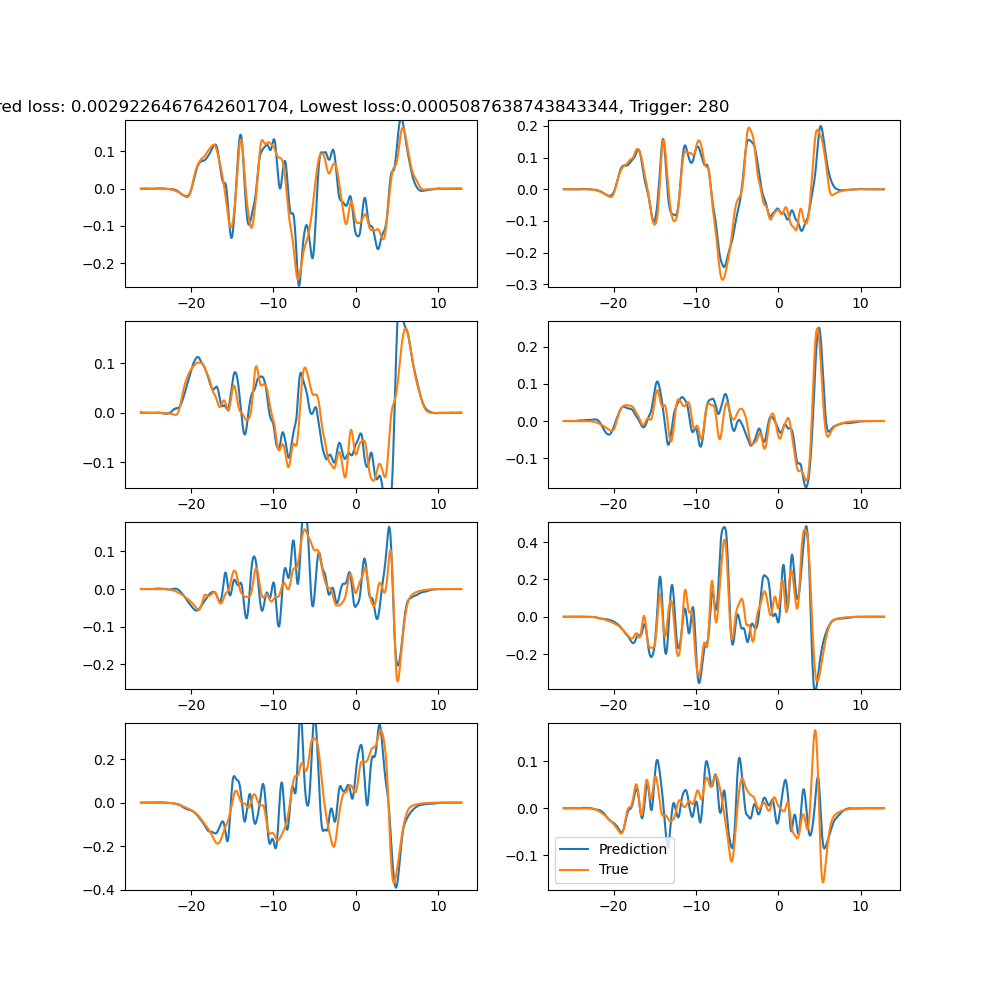

Epoch: 522:   0%|▏                                                                                            | 522/200000 [43:16:15<20574:54:12, 371.32s/it, lowest_loss=0.000509, pred_loss=0.00292, trigger=281]

In [ ]:
xdos_step = xdos[1] - xdos[0]
#shift_range = torch.tensor([x*xdos_step for x in range(0,1)])
shift_interval = 10
M_soap = JitteralignmentLinearModel(448, 778, n_train, xdos, 1e-11, "Adam", "cpu")
loss_history = M_soap.fit(train_dataloader_soap,None, None, 0.001, 200000)

In [87]:
consistency.shifted_ldos(ldos[0], xdos, -38)

tensor([ 1.2701e-80,  5.3363e-82,  2.1805e-83,  8.6658e-85,  3.3495e-86,
         1.2591e-87,  4.6036e-89,  1.6370e-90,  5.6612e-92,  1.9041e-93,
         6.2289e-95,  1.9817e-96,  6.1319e-98,  1.8453e-99, 5.4009e-101,
        1.5374e-102, 4.2562e-104, 1.1460e-105, 3.0009e-107,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0

In [88]:
train_dataloader_soap.dataset.alignment

tensor([-38., -39., -39., -39., -39., -39., -40., -40., -38., -38., -38., -38.,
        -38., -39., -40., -40., -40., -38., -39., -40., -40., -39., -39., -39.,
        -40., -40., -40., -40., -40., -39., -39., -39., -38., -40., -38., -38.,
        -39., -36., -39., -40., -40., -40., -39., -38., -40., -39., -39., -40.,
        -39., -39., -40., -38., -39., -39., -40., -40., -40., -39., -39., -40.,
        -40., -40., -40., -39., -39., -39., -38., -39., -39., -39., -39., -40.,
        -39., -39., -39., -39., -40., -39., -40., -40., -39., -39., -39., -40.,
        -40., -40., -39., -40., -40., -39., -39., -39., -39., -40., -39., -40.,
        -40., -40., -40., -39., -40., -40., -39., -40., -40., -39., -39., -38.,
        -40., -40., -39., -40., -39., -39., -39., -39., -38., -39., -39., -39.,
        -39., -39., -40., -39., -40., -38., -39., -39., -40., -39., -39., -40.,
        -40., -39., -40., -39., -39., -40., -40., -40., -39., -39., -37., -40.,
        -39., -40., -40., -40., -38., -3

Adam
jitteralignment, no bias - explodes
jitteralignment, no bias - with clamp, hits maximum on both ends

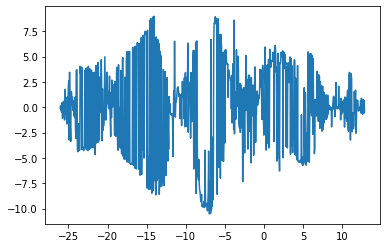

In [62]:
with torch.no_grad():
    plt.plot(xdos,M_soap(train_data_soap[:][0][1]))